In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, vstack, hstack

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize, MaxAbsScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD

from collections import Counter

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler,SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

from xgboost import XGBRegressor, XGBClassifier

from rank_bm25 import BM25Okapi

## Read Data

In [46]:
train_d1 = pd.read_json("domain1_train_data.json", lines=True)
train_d2 = pd.read_json("domain2_train_data.json", lines=True)
test = pd.read_json("test_data.json", lines=True)

## EDA

In [47]:
train_d1.head()

,text,label,id
0,"[6, 22, 34, 76, 501, 977, 1, 2514, 13623, 76, ...",0,0
1,"[222, 31, 4108, 104, 132, 361, 39, 2305, 12, 9...",0,1
2,"[736, 7194, 113, 12, 366, 2870, 123, 101, 12, ...",0,2
3,"[48, 1, 2025, 69, 361, 533, 327, 237, 4150, 13...",0,3
4,"[2973, 66, 1, 1493, 260, 2740, 50, 1027, 50, 1...",0,4


In [48]:
# If 'text' contains lists, we can analyze their length
train_d1['text_length'] = train_d1['text'].apply(len)
train_d2['text_length'] = train_d2['text'].apply(len)

In [49]:
# Statistical summary of text lengths by label
train_d1.groupby('label')['text_length'].describe()
train_d2.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,250.0,70.564000,3.622484,55.0,69.0,71.0,73.0,77.0
1,4750.0,80.587158,1.224738,70.0,80.0,80.0,81.0,91.0


In [50]:
# Correlation between text length and label
print("Correlation between text length and label d1:", 
      train_d1['text_length'].corr(train_d1['label']))

# Correlation between text length and label
print("Correlation between text length and label d2:", 
      train_d2['text_length'].corr(train_d2['label']))

Correlation between text length and label d1: 0.16134940245433266
Correlation between text length and label d2: 0.8346408259478301


In [51]:
# Examining the most common tokens
from collections import Counter
all_tokens = [token for text in train_d1['text'] for token in text]
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common(20)
print("Most common tokens in d1:", most_common_tokens) # (indice, frequency)

all_tokens = [token for text in train_d2['text'] for token in text]
token_counts = Counter(all_tokens)
most_common_tokens = token_counts.most_common(20)
print("Most common tokens in d2:", most_common_tokens) # (indice, frequency)

Most common tokens in d1: [(11, 4639), (1, 4141), (12, 2664), (4, 2560), (69, 1861), (22, 1759), (39, 1602), (101, 1519), (139, 1182), (13, 1055), (48, 985), (151, 969), (104, 891), (76, 810), (66, 713), (80, 684), (50, 673), (36, 639), (64, 626), (6, 622)]
Most common tokens in d2: [(1, 20613), (12, 13546), (4, 13084), (11, 12304), (39, 11195), (101, 9976), (69, 9928), (13, 7633), (139, 6352), (76, 5731), (151, 5565), (80, 4311), (36, 4245), (48, 3572), (22, 3459), (222, 3201), (64, 3086), (50, 2690), (238, 2508), (55, 2391)]


In [52]:
# Create a new feature for analysis
train_d1['unique_tokens'] = train_d1['text'].apply(lambda x: len(set(x)))
train_d1['token_diversity'] = train_d1['unique_tokens'] / train_d1['text_length']

train_d2['unique_tokens'] = train_d2['text'].apply(lambda x: len(set(x)))
train_d2['token_diversity'] = train_d2['unique_tokens'] / train_d2['text_length']

In [53]:
# Correlation between text length and label
print("Correlation between token diversity and label d1:", 
      train_d1['token_diversity'].corr(train_d1['label']))

# Correlation between text length and label
print("Correlation between token diversity and label d2:", 
      train_d2['token_diversity'].corr(train_d2['label']))

Correlation between token diversity and label d1: -0.1041082476069229
Correlation between token diversity and label d2: -0.16382331092609162


In [54]:
# Correlation between text length and label
print("Correlation between token diversity and label d1:", 
      train_d1['token_diversity'].corr(train_d1['label']))

# Correlation between text length and label
print("Correlation between token diversity and label d2:", 
      train_d2['token_diversity'].corr(train_d2['label']))

Correlation between token diversity and label d1: -0.1041082476069229
Correlation between token diversity and label d2: -0.16382331092609162


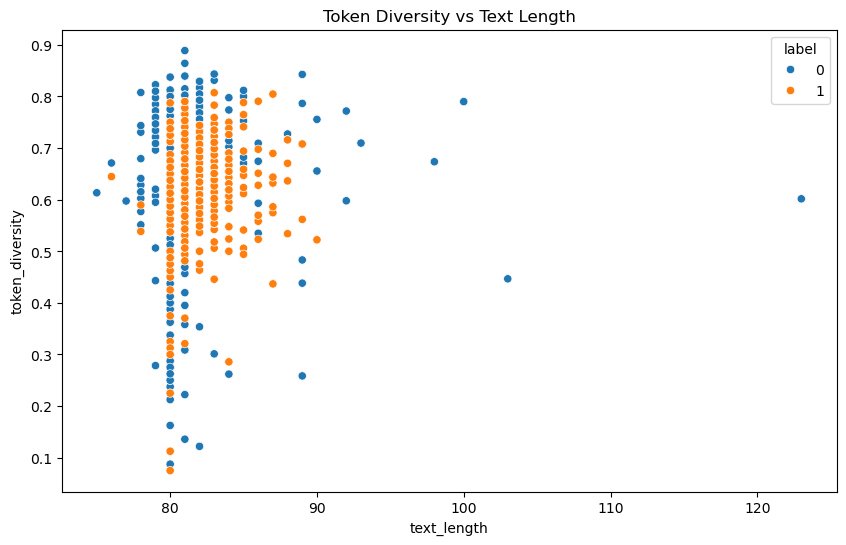

In [55]:
# Plot relationship between features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='text_length', y='token_diversity', hue='label', data=train_d1)
plt.title('Token Diversity vs Text Length')
plt.show()

In [56]:
train_d1["domain"] = 0
train_d2["domain"] = 1

In [57]:
train_d1.head()

,text,label,id,text_length,unique_tokens,token_diversity,domain
0,"[6, 22, 34, 76, 501, 977, 1, 2514, 13623, 76, ...",0,0,81,51,0.629630,0
1,"[222, 31, 4108, 104, 132, 361, 39, 2305, 12, 9...",0,1,80,56,0.700000,0
2,"[736, 7194, 113, 12, 366, 2870, 123, 101, 12, ...",0,2,84,62,0.738095,0
3,"[48, 1, 2025, 69, 361, 533, 327, 237, 4150, 13...",0,3,83,51,0.614458,0
4,"[2973, 66, 1, 1493, 260, 2740, 50, 1027, 50, 1...",0,4,80,56,0.700000,0


In [58]:
train_d2.head()

,text,label,id,text_length,unique_tokens,token_diversity,domain
0,"[22, 6065, 76, 119, 13027, 575, 219, 22, 2435,...",0,0,71,48,0.676056,1
1,"[1275, 1509, 12, 6113, 6287, 327, 411, 1139, 2...",0,1,73,59,0.808219,1
2,"[575, 2962, 529, 4624, 39, 279, 1012, 277, 76,...",0,2,73,51,0.698630,1
3,"[12, 6113, 2428, 69, 375, 1025, 2605, 76, 101,...",0,3,72,53,0.736111,1
4,"[529, 76, 1509, 861, 1, 645, 1, 5013, 237, 3, ...",0,4,70,57,0.814286,1


### SMOTE (Over Sampling)

In [59]:
# # This creates synthetic samples for the minority class in domain2
# ros = RandomOverSampler(random_state=42)
# # sampling_strategy='auto' will balance classes to have equal numbers 
# X_d2_resampled, y_d2_resampled = ros.fit_resample(X_d2_bow, y_d2)

In [60]:
# # Combine domain1 (original) with domain2 (resampled) data
# X_resampled = vstack([X_d1_bow, X_d2_resampled])
# y_resampled = pd.concat([y_d1, pd.Series(y_d2_resampled)])

## Training

In [61]:
merge = pd.concat([train_d1, train_d2], ignore_index=True)
merge = shuffle(merge, random_state=42)

In [62]:
X_d2 = train_d2["text"]
y_d2 = train_d2["label"]

X_d1 = train_d1["text"]
y_d1 = train_d1["label"]

vocab_size = 17119 + 1

In [63]:
# create a BoW from token indices
def tokens_to_bow(texts, vocab_size):
    rows, cols, counts = [], [], []
    for row_idx, text in enumerate(texts):
        token_counts = {}
        for token in text:
            token_counts[token] = token_counts.get(token, 0) + 1
        for token, count in token_counts.items():
            rows.append(row_idx)
            cols.append(token)
            counts.append(count)
    return csr_matrix((counts, (rows, cols)), shape=(len(texts), vocab_size))

In [64]:
def tokens_to_ngram_bow(texts, vocab_size, n_list=(1,2,3), min_freq=3):
    rows, cols, counts = [], [], []
    next_id  = vocab_size
    ngram_id = {}      # {tuple: id}
    freq_cnt = Counter()

    # 1st pass: count n‑gram freq
    for tokens in texts:
        for n in n_list[1:]:                 # skip unigram
            for i in range(len(tokens)-n+1):
                freq_cnt[tuple(tokens[i:i+n])] += 1

    # 2nd pass: build sparse rows
    for r, tokens in enumerate(texts):
        token_counts = Counter(tokens)       # unigram
        # add n‑gram
        for n in n_list[1:]:
            for i in range(len(tokens)-n+1):
                t = tuple(tokens[i:i+n])
                if freq_cnt[t] >= min_freq:
                    if t not in ngram_id:
                        ngram_id[t] = next_id
                        next_id += 1
                    token_counts[ngram_id[t]] += 1
        for c, cnt in token_counts.items():
            rows.append(r); cols.append(c); counts.append(cnt)

    X = csr_matrix((counts,(rows,cols)), shape=(len(texts), next_id))
    return X

In [65]:
# 只用 train 数据，避免信息泄漏 (data leakage)
token_freq = Counter()
for tokens in pd.concat([train_d1, train_d2], ignore_index=True)["text"]:
    token_freq.update(tokens)
RARE_TH = 5        # 出现次数 < 5 视为“罕见”(rare)

def build_numeric_features(text_series, token_freq, rare_th=RARE_TH):
    """
    Return: ndarray shape (n_samples, n_features)
            columns = [seq_len, mean_token_id, rare_ratio, token_diversity]
    """
    # 序列长度 (sequence length)
    seq_len = text_series.apply(len).values
    
    # 平均 token 索引 (mean token id)
    mean_token_id = text_series.apply(lambda ts: np.mean(ts) if len(ts) > 0 else 0).values
    
    # 罕见词占比 (rare_token_ratio)
    rare_ratio = text_series.apply(
        lambda ts: sum(token_freq[t] < rare_th for t in ts) / len(ts) if len(ts) > 0 else 0
    ).values

    # # num unique tokens in sentences
    # token_uniq = text_series.apply(lambda x: len(set(x))).values
    
    # 词多样性 (token_diversity = unique / length)
    token_div = text_series.apply(
        lambda ts: len(set(ts)) / len(ts) if len(ts) > 0 else 0
    ).values
    
    feats = np.vstack([seq_len, token_div]).T
    return feats.astype(np.float32)

### Prepare the data

In [66]:
# 0. 拼接所有文本
all_texts = pd.concat([merge["text"], test["text"]], ignore_index=True)

# 1. 一次性生成 n‑gram BoW
X_all = tokens_to_ngram_bow(all_texts, vocab_size, n_list=(1,2,3), min_freq=3)

# 2. 切分回 train / test
X_bow   = X_all[:len(merge)]
test_bow = X_all[len(merge):]

# === 3.2 数值特征部分 ===
num_feats_train = build_numeric_features(merge["text"], token_freq)   # ndarray
num_feats_test  = build_numeric_features(test["text"],  token_freq)

scaler = MaxAbsScaler()
num_feats_train = scaler.fit_transform(num_feats_train)   # 返回 sparse matrix
num_feats_test  = scaler.transform(num_feats_test)

# === 3.3 拼接 (concatenate) ===
X_train_final = hstack([X_bow, num_feats_train]).tocsr()  # (n_samples, vocab_size + 4) # 转换为 csr_matrix
X_test_final  = hstack([test_bow, num_feats_test]).tocsr()  # 转换为 csr_matrix

y = merge["label"]

### Merge + Resampling + Ensemble + OOF

In [68]:
def compute_idf(bow_matrix, vocab_size):
    """
    Convert a BoW matrix (raw counts) to TF-IDF vectors.
    
    Args:
        bow_matrix (csr_matrix): Sparse BoW matrix of shape (n_docs, vocab_size).
        vocab_size (int): Size of the vocabulary.
        
    Returns:
        csr_matrix: TF-IDF matrix with L2-normalized rows.
    """
    # Compute document frequency (DF) for each term
    bow_binary = bow_matrix.astype(bool).astype(int)  # Convert to binary (presence/absence)
    df = bow_binary.sum(axis=0)                       # Sum over documents (shape: [1, vocab_size])
    df = np.asarray(df).flatten()                     # Convert to 1D array
    
    # Compute IDF values with smoothing
    N = bow_matrix.shape[0]  # Total number of documents
    idf = np.log((N + 1) / (df + 1)) + 1
    
    return idf

def compute_tfidf(bow_matrix, vocab_size, idf):
    # Scale BoW columns by IDF to get TF-IDF
    tfidf = bow_matrix.multiply(idf)  # Element-wise multiplication (term-wise scaling)
    
    # L2-normalize rows (documents)
    tfidf = normalize(tfidf, norm='l2', axis=1)
    
    return tfidf

In [69]:
# X_bow = tokens_to_bow(merge["text"], vocab_size)
# test_bow = tokens_to_bow(test["text"], vocab_size)

# # Convert to TF-IDF
# idf = compute_idf(X_bow, vocab_size)
# X_tfidf = compute_tfidf(X_bow, vocab_size, idf)
# test_tfidf = compute_tfidf(test_bow, vocab_size, idf)

# y = merge["label"]
# domains = merge["domain"]

In [70]:
def predict_by_similarity(X_test, X_train, y_train, k=3):
    # Calculate cosine similarity between each test and train instance
    # This will give a matrix of shape (n_test, n_train)
    similarity_matrix = cosine_similarity(X_test, X_train)
    
    # For each test instance, find the indices of the k most similar training instances
    # argsort sorts in ascending order, so we take the last k elements
    top_k_indices = np.argsort(similarity_matrix, axis=1)[:, -k:]
    
    mean_predictions = np.array([
        np.mean(y_train.iloc[indices]) for indices in top_k_indices
    ])
    
    return mean_predictions

In [71]:
def predict_by_bm25_simple(X_test, X_train, y_train, k=3):
    # Convert sparse matrices to lists of indices where values are non-zero
    train_docs = [X_train[i].nonzero()[1] for i in range(X_train.shape[0])]
    test_docs = [X_test[i].nonzero()[1] for i in range(X_test.shape[0])]
    
    # Create BM25 object
    bm25 = BM25Okapi(train_docs)
    
    # For each test document, get BM25 scores for all training documents
    top_k_indices = []
    for test_doc in test_docs:
        scores = bm25.get_scores(test_doc)
        top_indices = np.argsort(scores)[-k:]
        top_k_indices.append(top_indices)
    
    mean_predictions = np.array([
        np.mean(y_train.iloc[indices]) for indices in top_k_indices
    ])
    
    return mean_predictions

In [ ]:
# def tta(test_tokens, model, token_freq_map=None, n_augmentations=10):
#     """More robust TTA with multiple augmentation strategies"""
#     all_preds = []
    
#     # Original prediction
#     original_bow = tokens_to_ngram_bow([test_tokens], vocab_size, n_list=(1,2,3), min_freq=3)
#     original_pred = model.predict_proba(original_bow)[0]
#     all_preds.append(original_pred)
    
#     # Weight original prediction more heavily (optional)
#     all_preds.append(original_pred)  # Add twice
    
#     augmentation_methods = [
#         # Mild deletion - remove ~5% of tokens
#         lambda t: token_deletion(t.copy(), p=0.05),
        
#         # Very mild swapping - swap just a couple tokens
#         lambda t: token_swap(t.copy(), n_swaps=min(2, len(t)//10)),
        
#         # Substitution with similar tokens
#         lambda t: token_substitution(t.copy(), token_freq_map, p=0.05) if token_freq_map else t.copy(),
        
#         # Combination: mild deletion + swap
#         lambda t: token_swap(token_deletion(t.copy(), p=0.03), n_swaps=1)
#     ]
    
#     # Generate augmentations
#     for _ in range(n_augmentations):
#         # Select random augmentation method
#         method = random.choice(augmentation_methods)
#         augmented = method(test_tokens)
        
#         # Ensure augmented sample isn't too different (optional, may need customization)
#         if len(set(augmented) & set(test_tokens)) / len(set(test_tokens)) < 0.7:
#             continue  # Skip if too different
            
#         # Convert to BOW and predict
#         augmented_bow = tokens_to_ngram_bow([augmented], vocab_size, n_list=(1,2,3), min_freq=3)
#         aug_pred = model.predict_proba(augmented_bow)[0]
#         all_preds.append(aug_pred)
    
#     # Average predictions
#     avg_prediction = np.mean(all_preds, axis=0)
#     return avg_prediction

In [ ]:
## out of fold predictions
oof_preds_sim = np.zeros(len(y), dtype=int)
oof_probs_sim = np.zeros(len(y))

oof_preds = np.zeros(len(y), dtype=int)
oof_probs = np.zeros(len(y))

test_preds = np.zeros(len(test))

# Stratify based on the domain as well
combined_target = merge["domain"].astype(str) + '_' + merge["label"].astype(str)

FOLDS = 10
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
for train_index, val_index in skf.split(X_train_final, combined_target):
    X_train = X_train_final[train_index]
    X_val = X_train_final[val_index]

    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    # Oversampling
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    # smote = SMOTE(random_state=42)
    # X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Predict with similarity
    mean_preds = predict_by_similarity(X_val, X_train_resampled, y_train_resampled)
    # mean_preds = predict_by_bm25_simple(X_val, X_train_resampled, y_train_resampled)
    binary_preds = (mean_preds > 0.5).astype(int)
    oof_preds_sim[val_index] = binary_preds
    oof_probs_sim[val_index] += mean_preds

    # Model prediction
    clf1 = LogisticRegression(max_iter=1000, C=0.1, solver='liblinear', random_state=42)
    clf2 = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber", alpha=0.1, penalty='l2')
    # clf3 = RandomForestClassifier(n_estimators=200) 
    eclf = VotingClassifier(estimators=[('lr', clf1), ('sgd', clf2)], voting='soft')

    eclf.fit(X_train_resampled, y_train_resampled)

    # direct output for valication data, probability for test for mean value later
    oof_preds[val_index] = eclf.predict(X_val)
    oof_probs[val_index] += eclf.predict_proba(X_val)[:, 1]

    # use model for test prediction
    test_preds += eclf.predict_proba(X_test_final)[:, 1]

    # # Apply TTA for each test sample
    # for i, tokens in enumerate(test):
    #     # Get predictions with TTA
    #     tta_probs = tta(tokens, eclf, token_freq_map, n_augmentations=5)
    #     test_preds[i] += tta_probs

test_preds /= FOLDS # Average across folds

test_labels = (test_preds > 0.5).astype(int)
test_labels

/opt/anaconda3/envs/sml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sml/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/opt/anaconda3/envs/sml/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/opt/anaconda3/envs/sml/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/sml/lib/python3.9/site-packages/sklearn/base.py:484: FutureWarning: 

array([1, 0, 0, ..., 0, 0, 1])

In [73]:
# ## out of fold predictions
# oof_preds_sim = np.zeros(len(y), dtype=int)
# oof_probs_sim = np.zeros(len(y))

# oof_preds = np.zeros(len(y), dtype=int)
# oof_probs = np.zeros(len(y))

# test_preds = np.zeros(len(test))

# # Stratify based on the domain as well
# combined_target = merge["domain"].astype(str) + '_' + merge["label"].astype(str)

# FOLDS = 10
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# for train_index, val_index in skf.split(X_train_final, combined_target):
#     X_train = X_train_final[train_index]
#     X_val = X_train_final[val_index]

#     y_train = y.iloc[train_index]
#     y_val = y.iloc[val_index]

#     # 1. Apply dimensionality reduction
#     svd = TruncatedSVD(n_components=1000, random_state=42)
#     X_train_reduced = svd.fit_transform(X_train)
#     X_val_reduced = svd.transform(X_val)
    
#     # 2. Apply SMOTE on the reduced dimensions
#     smote = SMOTE(random_state=42)
#     X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced, y_train)

#     # 3. For similarity prediction, use the reduced+resampled data
#     # Need to modify the similarity function to work with dense arrays
#     # mean_preds = predict_by_similarity(X_val_reduced, X_train_resampled, y_train_resampled)
#     # binary_preds = (mean_preds > 0.5).astype(int)
#     # oof_preds_sim[val_index] = binary_preds
#     # oof_probs_sim[val_index] += mean_preds

#     # 4. Train models on the reduced+resampled data
#     clf1 = LogisticRegression(max_iter=1000, C=0.1, solver='liblinear', random_state=42)
#     clf2 = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber", alpha=0.1, penalty='l2')
#     eclf = VotingClassifier(estimators=[('lr', clf1), ('sgd', clf2)], voting='soft')

#     eclf.fit(X_train_resampled, y_train_resampled)

#     # 5. Predict on the reduced validation data
#     oof_preds[val_index] = eclf.predict(X_val_reduced)
#     oof_probs[val_index] += eclf.predict_proba(X_val_reduced)[:, 1]

#     # 6. For test predictions, reduce the test data with the same SVD
#     X_test_reduced = svd.transform(X_test_final)
#     test_preds += eclf.predict_proba(X_test_reduced)[:, 1]

# test_preds /= FOLDS

# test_labels = (test_preds > 0.5).astype(int)
# test_labels

In [74]:
acc = accuracy_score(y, oof_preds_sim)
print(f"Overall OOF accuracy with similarity: {acc:.4f}")

Overall OOF accuracy with similarity: 0.8922


In [75]:
acc = accuracy_score(y, oof_preds)
print(f"Overall OOF accuracy: {acc:.4f}")

Overall OOF accuracy: 0.9713


In [76]:
final_oof = (oof_probs + oof_probs_sim) / 2
final_oof = (final_oof > 0.5).astype(int)

acc = accuracy_score(y, final_oof)
print(f"Overall OOF accuracy with similarity + model pred: {acc:.4f}")

Overall OOF accuracy with similarity + model pred: 0.9147


In [77]:
print(classification_report(y, oof_preds_sim))

              precision    recall  f1-score   support

           0       0.60      0.40      0.48       750
           1       0.92      0.96      0.94      5250

    accuracy                           0.89      6000
   macro avg       0.76      0.68      0.71      6000
weighted avg       0.88      0.89      0.88      6000



In [78]:
print(classification_report(y, oof_preds))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       750
           1       0.98      0.99      0.98      5250

    accuracy                           0.97      6000
   macro avg       0.94      0.93      0.93      6000
weighted avg       0.97      0.97      0.97      6000



In [79]:
print(classification_report(y, final_oof))

              precision    recall  f1-score   support

           0       0.75      0.47      0.58       750
           1       0.93      0.98      0.95      5250

    accuracy                           0.91      6000
   macro avg       0.84      0.73      0.77      6000
weighted avg       0.91      0.91      0.91      6000



In [80]:
sub = pd.read_csv("sample.csv")
sub["class"] = test_labels
sub.to_csv("submission.csv", index=False)

In [81]:
# ## out of fold predictions
# oof_preds = np.zeros(len(y), dtype=int)
# test_preds = np.zeros(len(test))

# FOLDS = 10
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# for train_index, val_index in skf.split(X_bow, y):
#     X_train = X_bow[train_index]
#     X_val = X_bow[val_index]

#     y_train = y.iloc[train_index]
#     y_test = y.iloc[val_index]

#     # train with LogisticReg
#     model = LogisticRegression(
#         max_iter=1000,
#         C=1.0,
#         solver='liblinear'
#     )
#     model.fit(X_train, y_train)

#     # direct output for valication data, probability for test for mean value later
#     oof_preds[val_index] = model.predict(X_val)
#     test_preds += model.predict_proba(test_bow)[:, 1]

# test_preds /= FOLDS

In [82]:
# test_labels = (test_preds > 0.5).astype(int)
# test_labels

In [83]:
# acc = accuracy_score(y, oof_preds)
# print(f"Overall OOF accuracy: {acc:.4f}")

### Merge + BoW + ensemble + OOF

### Tuning

In [84]:
# from sklearn.model_selection import GridSearchCV, cross_val_score
# from sklearn.metrics import accuracy_score, roc_auc_score

# # Define parameter grids for each model
# lr_param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'solver': ['liblinear', 'saga']
# }

# nb_param_grid = {
#     'alpha': [0.001, 0.01, 0.1, 1, 10]
# }

# sgd_param_grid = {
#     'alpha': [0.0001, 0.001, 0.01, 0.1],
#     'loss': ['log_loss', 'modified_huber', 'hinge'],
#     'penalty': ['l2', 'l1', 'elasticnet']
# }

# # Create base models
# lr = LogisticRegression(max_iter=1000, random_state=42)
# nb = MultinomialNB()
# sgd = SGDClassifier(max_iter=8000, tol=1e-4, random_state=42)

# # Perform grid search for each model
# print("Tuning Logistic Regression...")
# lr_grid = GridSearchCV(lr, lr_param_grid, cv=5, scoring='roc_auc')
# lr_grid.fit(X_bow, y)
# print(f"Best LR params: {lr_grid.best_params_}")
# print(f"Best LR score: {lr_grid.best_score_:.4f}")

# print("\nTuning MultinomialNB...")
# nb_grid = GridSearchCV(nb, nb_param_grid, cv=5, scoring='roc_auc')
# nb_grid.fit(X_bow, y)
# print(f"Best NB params: {nb_grid.best_params_}")
# print(f"Best NB score: {nb_grid.best_score_:.4f}")

# print("\nTuning SGDClassifier...")
# sgd_grid = GridSearchCV(sgd, sgd_param_grid, cv=5, scoring='roc_auc')
# sgd_grid.fit(X_bow, y)
# print(f"Best SGD params: {sgd_grid.best_params_}")
# print(f"Best SGD score: {sgd_grid.best_score_:.4f}")


# # Now tune the voting classifier weights
# # Create base models with best parameters
# best_lr = LogisticRegression(**lr_grid.best_params_, max_iter=1000, random_state=42)
# best_nb = MultinomialNB(**nb_grid.best_params_)
# best_sgd = SGDClassifier(**sgd_grid.best_params_, max_iter=8000, tol=1e-4, random_state=42)

# # Define weight combinations to try
# weight_combinations = [
#     [0.4, 0.3, 0.3],  # Equal-ish weights
#     [0.6, 0.2, 0.2],  # More weight to LR
#     [0.2, 0.6, 0.2],  # More weight to NB
#     [0.2, 0.2, 0.6],  # More weight to SGD
#     [0.5, 0.3, 0.2],  # Balanced with LR emphasis
#     [0.3, 0.5, 0.2],  # Balanced with NB emphasis
#     [0.3, 0.2, 0.5]   # Balanced with SGD emphasis
# ]

# # Store results for each weight combination
# weight_results = []
# for weights in weight_combinations:
#     eclf = VotingClassifier(
#         estimators=[('lr', best_lr), ('mnb', best_nb), ('sgd', best_sgd)],
#         weights=weights,
#         voting='soft'
#     )
    
#     # Perform cross-validation
#     cv_scores = cross_val_score(eclf, X_bow, y, cv=5, scoring='roc_auc')
#     mean_score = cv_scores.mean()
#     std_score = cv_scores.std()
    
#     weight_results.append({
#         'weights': weights,
#         'mean_score': mean_score,
#         'std_score': std_score
#     })
    
#     print(f"\nWeights: {weights}")
#     print(f"Mean ROC-AUC: {mean_score:.4f} ± {std_score:.4f}")

# # Find the best weight combination
# best_weights = max(weight_results, key=lambda x: x['mean_score'])['weights']
# print(f"\nBest weight combination: {best_weights}")

In [85]:
# ## out of fold predictions
# oof_preds = np.zeros(len(y), dtype=int)
# test_preds = np.zeros(len(test))

# # Stratify based on the domain as well
# combined_target = merge['domain'].astype(str) + '_' + merge['label'].astype(str)

# FOLDS = 10
# skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)
# for train_index, val_index in skf.split(X_bow, combined_target):
#     X_train = X_bow[train_index]
#     X_val = X_bow[val_index]

#     y_train = y.iloc[train_index]
#     y_test = y.iloc[val_index]

#     clf1 = LogisticRegression(max_iter=1000, C=0.1, solver='liblinear', random_state=42)
#     clf2 = MultinomialNB(alpha=1)
#     clf3 = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber", alpha=0.1, penalty='l2') 

#     eclf = VotingClassifier(estimators=[('lr', clf1), ('mnb', clf2), ('sgd', clf3)], voting='soft')

#     eclf.fit(X_train, y_train)

#     # direct output for valication data, probability for test for mean value later
#     oof_preds[val_index] = eclf.predict(X_val)
#     test_preds += eclf.predict_proba(test_bow)[:, 1]

# test_preds /= FOLDS

# test_labels = (test_preds > 0.5).astype(int)
# test_labels

In [86]:
# acc = accuracy_score(y, oof_preds)
# print(f"Overall OOF accuracy: {acc:.4f}")

In [87]:
# Overall OOF accuracy: 0.9563
# Overall OOF accuracy: 0.9648 with xgb

## Submission

In [88]:
# sub = pd.read_csv("sample.csv")
# sub["class"] = test_labels
# sub.to_csv("submission.csv", index=False)